In [1]:
import tqdm
import torch
import transformers
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq
from transformers import AdamW
from IPython.display import clear_output


device = 'cuda'

In [2]:
model_checkpoint = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)


In [129]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)
model = model.to(device)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [130]:
df = pd.read_csv("diff_data.csv", sep = '\t')
df = df.dropna()
df = df.reset_index(drop=True)
df.head()

,Math expression,Derivative
0,sin(x + x),2*cos(2*x)
1,sin(exp((sqrt(x)))),exp(sqrt(x))*cos(exp(sqrt(x)))/(2*sqrt(x))
2,exp(x) + sin(x),exp(x) + cos(x)
3,--x,1
4,-x + sqrt(x),-1 + 1/(2*sqrt(x))


In [131]:
class CustomDataset(Dataset):
    def __init__(self, datafr):
        self.df = datafr

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        math_expr = self.df['Math expression'][idx]
        label = self.df['Derivative'][idx]
        
        return {"input_ids": tokenizer(math_expr)["input_ids"], "labels": tokenizer(label)["input_ids"]}

In [132]:
train_data, test_data = train_test_split(df, test_size = 0.15, random_state=42)
train_data = train_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)
train_data

,Math expression,Derivative
0,(-x / 4),-1/4
1,-x * -x - sqrt(x + x),2*x - sqrt(2)/(2*sqrt(x))
2,--8 / x / -4,2/x**2
3,sqrt(x - 6) * sqrt(sqrt(1)),1/(2*sqrt(x - 6))
4,ln(sqrt(x)) * -x / x,-1/(2*x)
...,...,...
10291,cos(2 + x / x / x),sin(2 + 1/x)/x**2
10292,cos(x * x) / -sin(x),2*x*sin(x**2)/sin(x) + cos(x)*cos(x**2)/sin(x)**2
10293,-x + 6 / ln(x) - sqrt(cos(x)) - -x / -x,sin(x)/(2*sqrt(cos(x))) - 1 - 6/(x*log(x)**2)
10294,x / x * sin(x),cos(x)


In [133]:
train_dataset = CustomDataset(train_data)
test_dataset = CustomDataset(test_data)

In [134]:
batch_size = 32
test_dataloader = DataLoader(test_dataset,collate_fn = data_collator,  batch_size=batch_size)
train_dataloader = DataLoader(train_dataset,collate_fn = data_collator, batch_size=batch_size)

In [135]:
optimizer = AdamW(model.parameters(), lr=3e-4)
num_train_epochs = 20


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


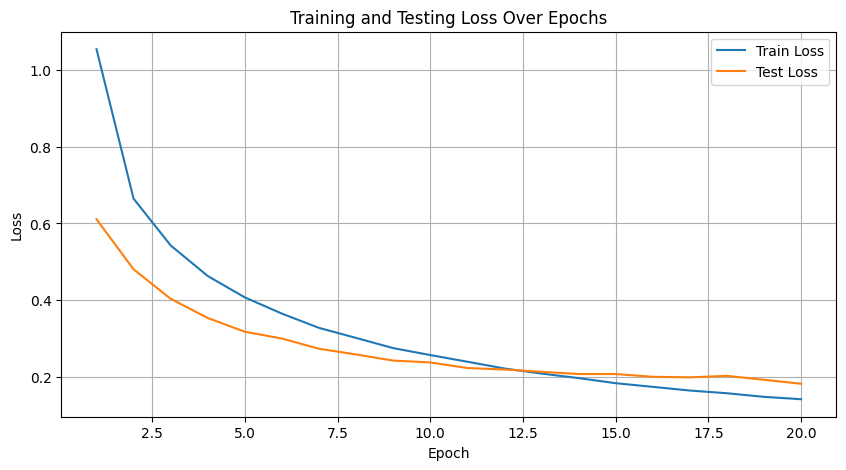

Epoch 20 | Train Loss: 0.1426 | Test Loss: 0.1829


In [136]:
train_losses = []
test_losses = []

for epoch in range(num_train_epochs):
    
    # Обучение
    model.train()
    loss_on_batches = []
    for i, batch in enumerate(tqdm.notebook.tqdm(train_dataloader)):
        
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        loss_on_batches.append(loss.item())
        
        optimizer.step()
        optimizer.zero_grad()

    
    avg_train_loss = sum(loss_on_batches) / len(loss_on_batches)
    train_losses.append(avg_train_loss)

    
    model.eval()
    loss_on_batches = []
    for batch in tqdm.notebook.tqdm(test_dataloader):
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)
        loss = outputs.loss
        loss_on_batches.append(loss.item())
        
    
    avg_test_loss = sum(loss_on_batches) / len(loss_on_batches)
    test_losses.append(avg_test_loss)

    

    
    clear_output(wait=True) 
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epoch + 2), train_losses, label='Train Loss')
    plt.plot(range(1, epoch + 2), test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.show()
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f}")


In [137]:
def make_pred(model, expr):
    with torch.no_grad():
        preds = model.generate(input_ids = torch.tensor(tokenizer(expr)["input_ids"]).to(device).view(1,-1))
    tokenizer.decode(np.array(preds.cpu()[0]))
    generated_text = tokenizer.decode(np.array(preds.cpu()[0]))
    return generated_text.replace('<pad>', '').replace('</s>', '') 

In [144]:
make_pred(model, 'x*x')

' 2*x'

In [145]:
make_pred(model, ' x*x + exp(2*x)')

' 2*x + 2*exp(2*x)'

In [146]:
make_pred(model, ' x*x + exp(2*x) + sin(x)')

' 2*x + 2*exp(2*x) + cos(x)'

In [149]:
make_pred(model, ' x*x + exp(2*x) + sin(cos(x))') # тут ошибся

' 2*x - sin(x)*cos(cos(x))'